In [53]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils.py import load_embeddings

In [12]:
def get_invlists(index): 
    invlists = index.invlists
    all_ids = []
    bins = []
    for listno in range(index.nlist): 
        ls = invlists.list_size(listno)
        if ls == 0: continue
        ids = faiss.rev_swig_ptr(invlists.get_ids(listno), ls).copy()
        all_ids.append(ids)
        bins.append(len(ids))
    del index
    return all_ids, bins

In [90]:
arch = 'resnet50' # resnet18, resnet34, resnet50, resnet101, mobilenetv2
root = f'../../../inference_array/{arch}/'
model = 'mrl'
dataset = '1K' # 1K, 4K, V2, inat

In [ ]:
if faiss.get_num_gpus() == 0:
    raise Exception("Please use a GPU!")

In [92]:
config = 'ivf'
nlist = 1024
dlist = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
per_query_matches_in_assigned_cluster_list = []

print("D, nlist, acc")
for dim in dlist:
    _, queryset, db_labels, query_labels, _, _ = load_embeddings(model, dataset, dim, arch=arch)
    
    model = f'{model}-{config}/{dim}/'
    index_file = root+'index_files/'+model+f"1K_ivf_nlist{nlist}_d{dim}.index"
    index = faiss.read_index(index_file)
    all_ids, counts_per_cell_rr = get_invlists(index)
    D, I = index.quantizer.search(queryset, 1)

    per_query_matches_in_assigned_cluster = []
    for i, q in enumerate(I):
        assigned_cluster_id = q[0]
        nodes_in_assigned_cluster = all_ids[assigned_cluster_id]
        labels_nodes_in_assigned_cluster = db_labels[nodes_in_assigned_cluster]
        query_label = query_labels[i]
        per_query_matches_in_assigned_cluster.append(
            np.sum(query_label == labels_nodes_in_assigned_cluster)/len(nodes_in_assigned_cluster)
        )

    print("%d, %d, %.4f" %(dim, nlist, np.mean(per_query_matches_in_assigned_cluster)))
    per_query_matches_in_assigned_cluster_list.append(per_query_matches_in_assigned_cluster)

D, nlist, acc
8, 1024, 0.4989
16, 1024, 0.5625
32, 1024, 0.5662
64, 1024, 0.5590
128, 1024, 0.5520
256, 1024, 0.5528
512, 1024, 0.5485
1024, 1024, 0.5481
2048, 1024, 0.5450


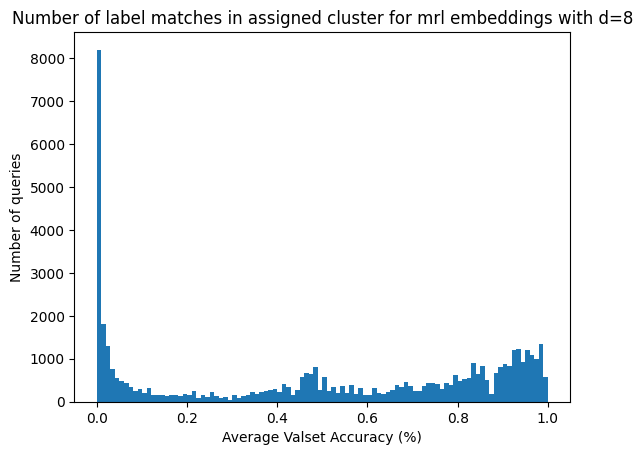

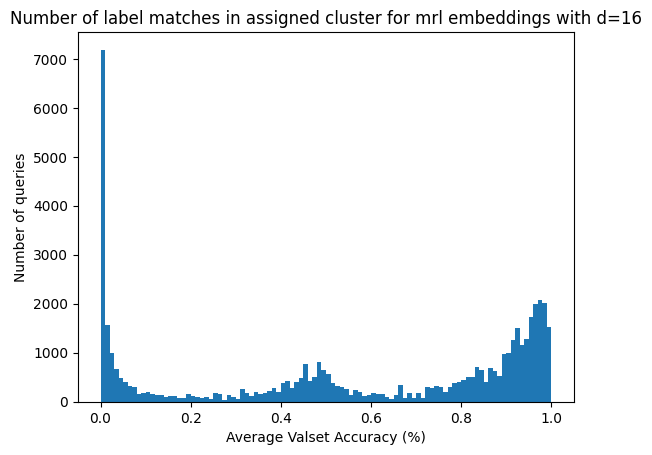

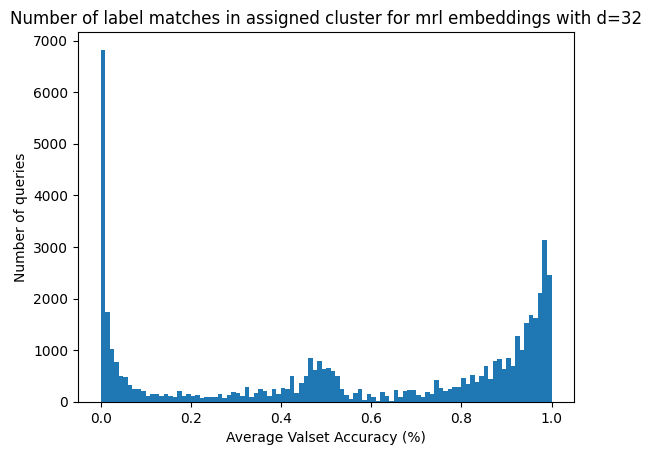

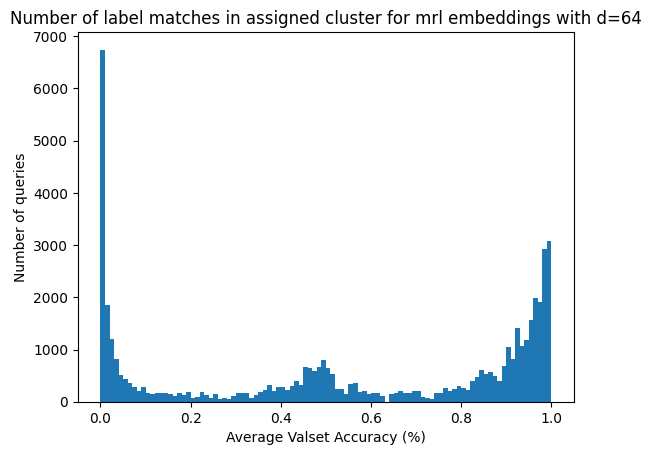

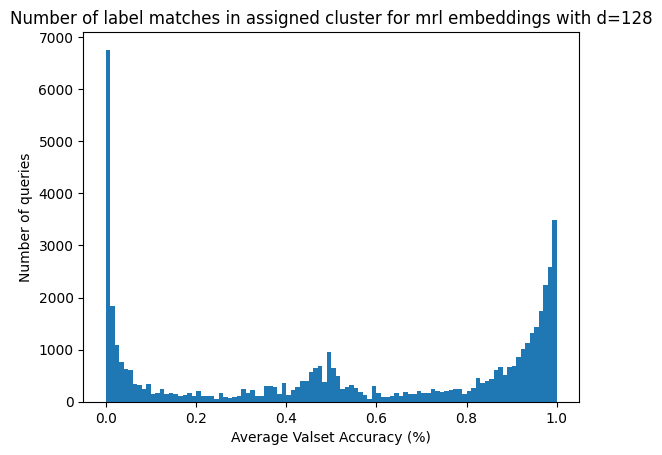

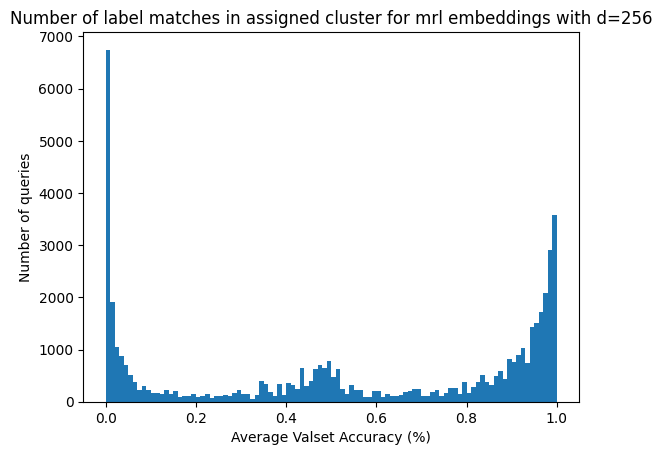

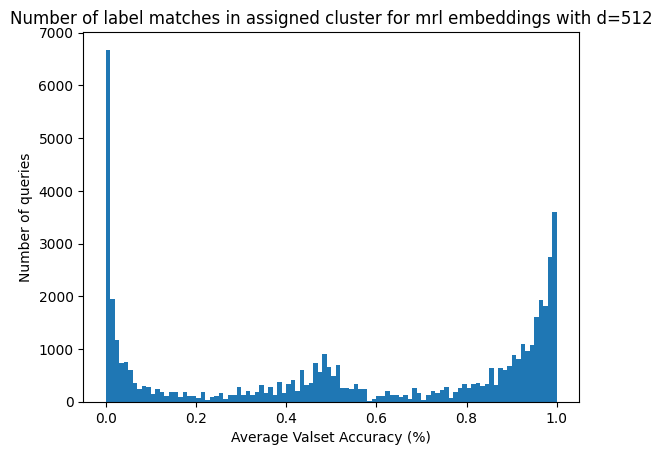

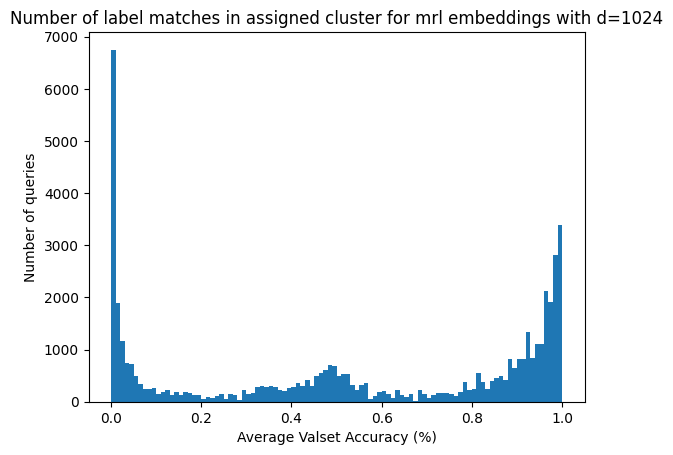

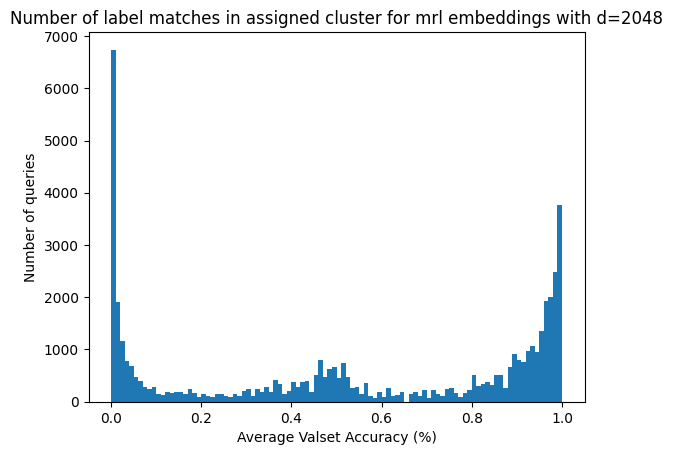

In [93]:
dlist = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for i, matches_hist in enumerate(per_query_matches_in_assigned_cluster_list):
    plt.hist(matches_hist, bins=100)
    plt.xlabel('Average Valset Accuracy (%)') 
    plt.ylabel('Number of queries') 
    plt.title("Number of label matches in assigned cluster for "+model+" embeddings with d="+str(dlist[i]))
    
    plt.show()